In [16]:
import os
import shutil
import random
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [67]:
img_size = 64
sample_size = 5000
dir_name = '20190222'
height = img_size
width = img_size
channels = 3
num_classes = 32

In [68]:
res_dir = '/Users/seino/Documents/res/09_DeepLearning/'
img_dir = os.path.join(res_dir, "img")
to_dir = os.path.join(img_dir, 'Teeth_Only')
wg_dir = os.path.join(img_dir, 'With_Gingiva')
to_lo = os.path.join(to_dir, 'Lo')
to_up = os.path.join(to_dir, 'Up')
wg_lo = os.path.join(wg_dir, 'Lo')
wg_up = os.path.join(wg_dir, 'Up')
target_list = [to_lo, to_up, wg_lo, wg_up]
playground_dir = os.path.join(res_dir, 'playground')
present_dir = os.path.join(playground_dir, dir_name)
store_dir = os.path.join(present_dir, 'dataset')
my_log_dir = os.path.join(present_dir, 'log_dir')
os.mkdir(present_dir)
os.mkdir(my_log_dir)
os.mkdir(store_dir)

FileExistsError: [Errno 17] File exists: '/Users/seino/Documents/res/09_DeepLearning/playground/20190222'

In [69]:
def k_hot_encode(fn):
    dent = [
    11, 12, 13, 14, 15, 16, 17, 18,
    21, 22, 23, 24, 25, 26, 27, 28,
    31, 32, 33, 34, 35, 36, 37, 38,
    41, 42, 43, 44, 45, 46, 47, 48]
    k_hot_dentition = [0]*32
    fn = fn.strip('[').strip('.png').strip(']')
    fn = fn.split(',')
    fn = [int(k) for k in fn]
    for t in fn:
        if t in dent:
            p = dent.index(t)
            k_hot_dentition[p] = 1
    return k_hot_dentition

In [71]:
for target in target_list:
    target_dir = os.path.join(target, str(img_size))
    fn = os.listdir(target_dir)
    random.shuffle(fn)
    extract_fn = fn[:sample_size//4]
    for k in extract_fn:
        src = os.path.join(target_dir, k)
        dst = os.path.join(store_dir,k)
        shutil.copyfile(src, dst)

In [73]:
X = []
Y = []
fn = os.listdir(store_dir)
fn.remove('.DS_Store')
for tl in fn:
    dst = os.path.join(store_dir, tl)
    img = img_to_array(load_img(dst))
    X.append(img)
    k_hot_dentition = k_hot_encode(tl)
    Y.insert(-1, k_hot_dentition)

In [74]:
X = np.asarray(X)
Y = np.asarray(Y)
X = X.astype('float32')
X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=111)

In [75]:
model = models.Sequential()
model.add(layers.SeparableConv2D(128, 3, activation='relu', input_shape=(height, width, channels)))
model.add(layers.SeparableConv2D(256, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.SeparableConv2D(256, 3, activation='relu'))
model.add(layers.SeparableConv2D(512, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_7 (Separabl (None, 62, 62, 128)       539       
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 60, 60, 256)       34176     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 28, 28, 256)       68096     
_________________________________________________________________
separable_conv2d_10 (Separab (None, 26, 26, 512)       133888    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 512)       0         
_________________________________________________________________
separable_conv2d_11 (Separab (None, 11, 11, 128)       70272     
__________

In [77]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir = my_log_dir,
        histogram_freq=1,
        embeddings_freq=1
        )
]

In [78]:
history = model.fit(X_train, y_train, batch_size=20, epochs=5, validation_data = (X_test, y_test), verbose = 0)

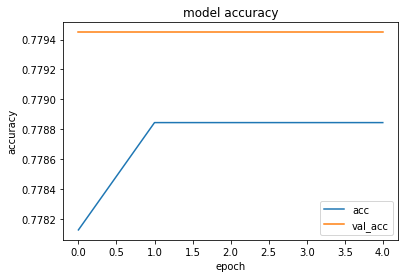

In [79]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()